In [ ]:
!pip -q install sympy "rfdetr[metrics]"

from google.colab import drive
drive.mount("/content/drive")

dataset_dir = "/content/ABOShipsDataset(COCO)"
!unzip -q /content/drive/MyDrive/Deep\ Learning/datasets/ABOShipsDataset\(COCO\).zip -d /content/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 21.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from rfdetr import RFDETRBase

dataset_dir = "/content/ABOShipsDataset(COCO)"
run_dir = "/content/drive/MyDrive/Deep Learning/RF-DETR/runs/abo_rfdetr_fixed"

model = RFDETRBase()
model.train(
    dataset_dir=dataset_dir,
    epochs=30,
    batch_size=4,
    grad_accum_steps=4,
    lr=1e-4,
    resolution=896,     # multiple of 56
    output_dir=run_dir,
    checkpoint_interval=1,
    early_stopping=True,
    tensorboard=True,
    verbose=True,       # more console output
    log_interval=10     # print every 10 steps
)

Output hidden; open in https://colab.research.google.com to view.

# Prediction

In [ ]:
# Inference with your fine-tuned RF-DETR
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

run_dir = "/content/drive/MyDrive/Deep Learning/RF-DETR/runs/abo_rfdetr_fixed"
ckpt = f"{run_dir}/checkpoint_best_total.pth"  # recommended for inference

# Match the resolution you trained with (you used 896)
model = RFDETRBase(pretrain_weights=ckpt, resolution=896)  # loads your weights
model.optimize_for_inference()  # optional speed-up on inference :contentReference[oaicite:1]{index=1}

img_path = "/content/ABOShipsDataset(COCO)/test/201806260801_018.png"  # <-- put your image path
dets = model.predict(img_path, threshold=0.5)  # accepts path/PIL/np/torch inputs :contentReference[oaicite:2]{index=2}

# OPTIONAL: label names (if you have custom classes)
# If you have a list of class names, use it; otherwise just show class IDs.
try:
    import json, os
    ann = None
    for split in ["valid", "val", "test", "train"]:
        p = os.path.join("/content/ABOShipsDataset(COCO)", split, "_annotations.coco.json")
        if os.path.exists(p): ann = p; break
    CLASS_NAMES = None
    if ann:
        cats = json.load(open(ann))["categories"]
        id2name = {c["id"]: c["name"] for c in cats}
        CLASS_NAMES = [id2name[i] for i in sorted(id2name.keys())]
    labels = [f"{(CLASS_NAMES[c] if CLASS_NAMES else c)} {s:.2f}"
              for c, s in zip(dets.class_id, dets.confidence)]
except Exception:
    labels = [f"{c} {s:.2f}" for c, s in zip(dets.class_id, dets.confidence)]

# Visualize
image = Image.open(img_path).convert("RGB")
annot = sv.BoxAnnotator().annotate(image.copy(), dets)
annot = sv.LabelAnnotator().annotate(annot, dets, labels)
annot.save("/content/pred.jpg")
print("Saved:", "/content/pred.jpg")


Loading pretrain weights


reinitializing detection head with 10 classes
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Saved: /content/pred.jpg



## Evaluation on Test Set — Ultralytics-style PR & F1-Confidence Curves

This section evaluates the trained RF-DETR model on the test split and produces:
- Precision–Recall (PR) curve at IoU=0.50 (matches Ultralytics' default for curves)
- F1 vs Confidence curve for selecting an operating threshold

We follow the Ultralytics matching approach: predictions are sorted by score and greedily matched to ground truth per class at the chosen IoU threshold; precision/recall are computed cumulatively across thresholds.


In [ ]:

# --- Helpers: COCO loading, IoU, matching, PR/F1 computation, plotting ---
import os, json, collections, time
from typing import Dict, Any, List
import numpy as np
import matplotlib.pyplot as plt

def box_iou_xyxy(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Pairwise IoU between boxes in xyxy format."""
    if a.size == 0 or b.size == 0:
        return np.zeros((a.shape[0], b.shape[0]), dtype=float)
    tl = np.maximum(a[:, None, :2], b[None, :, :2])
    br = np.minimum(a[:, None, 2:], b[None, :, 2:])
    wh = (br - tl).clip(min=0)
    inter = wh[..., 0] * wh[..., 1]
    area_a = (a[:, 2] - a[:, 0]).clip(min=0) * (a[:, 3] - a[:, 1]).clip(min=0)
    area_b = (b[:, 2] - b[:, 0]).clip(min=0) * (b[:, 3] - b[:, 1]).clip(min=0)
    union = area_a[:, None] + area_b[None, :] - inter
    iou = np.divide(inter, union, out=np.zeros_like(inter, dtype=float), where=union > 0)
    return iou

def coco_load_annotations(coco_json_path: str) -> Dict[str, Any]:
    with open(coco_json_path, "r", encoding="utf-8") as f:
        coco = json.load(f)
    id2img = {im["id"]: im for im in coco["images"]}
    id2cat = {c["id"]: c for c in coco["categories"]}
    gts = collections.defaultdict(list)
    total_by_class = collections.Counter()
    for ann in coco["annotations"]:
        if ann.get("iscrowd", 0):
            continue
        x, y, w, h = ann["bbox"]
        xyxy = [x, y, x + w, y + h]
        gts[(ann["image_id"], ann["category_id"])].append(xyxy)
        total_by_class[ann["category_id"]] += 1
    return {"id2img": id2img, "id2cat": id2cat, "gts": gts, "total_by_class": total_by_class, "raw": coco}

def rf_detr_predict_dataset(model, image_dir: str, coco_dict: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Run RF-DETR inference on each COCO test image; return list of {image_id, cls, conf, box}."""
    preds = []
    for im in coco_dict["raw"]["images"]:
        path = os.path.join(image_dir, im["file_name"])
        dets = model.predict(path, threshold=0.0)  # collect all, filter by thresholds later
        xyxy = np.asarray(dets.xyxy, dtype=float)
        conf = np.asarray(dets.confidence, dtype=float)
        cls = np.asarray(dets.class_id, dtype=int)
        for b, s, c in zip(xyxy, conf, cls):
            preds.append({"image_id": im["id"], "cls": int(c), "conf": float(s), "box": b.tolist()})
    preds.sort(key=lambda d: d["conf"], reverse=True)
    return preds

def compute_pr_arrays(preds: List[Dict[str, Any]], coco_info: Dict[str, Any], iou_thr=0.50):
    """Micro-averaged PR (and F1) arrays across all classes at a given IoU threshold."""
    gts = coco_info["gts"]
    total_gt = sum(coco_info["total_by_class"].values())
    if total_gt == 0:
        raise ValueError("No ground-truth boxes in annotations.")
    used = {k: np.zeros(len(v), dtype=bool) for k, v in gts.items()}
    scores, tps, fps = [], [], []
    for p in preds:
        key = (p["image_id"], p["cls"])
        gt_boxes = gts.get(key, [])
        if not gt_boxes:
            scores.append(p["conf"]); tps.append(0); fps.append(1); continue
        gt = np.asarray(gt_boxes, dtype=float)
        ious = box_iou_xyxy(np.asarray([p["box"]], dtype=float), gt)[0]
        if ious.size == 0:
            scores.append(p["conf"]); tps.append(0); fps.append(1); continue
        best_i = int(np.argmax(ious))
        if ious[best_i] >= iou_thr and not used[key][best_i]:
            used[key][best_i] = True
            scores.append(p["conf"]); tps.append(1); fps.append(0)
        else:
            scores.append(p["conf"]); tps.append(0); fps.append(1)
    scores = np.asarray(scores); tps = np.asarray(tps, dtype=float); fps = np.asarray(fps, dtype=float)
    order = np.argsort(-scores)
    scores, tps, fps = scores[order], tps[order], fps[order]
    cum_tp = np.cumsum(tps); cum_fp = np.cumsum(fps)
    precision = np.divide(cum_tp, (cum_tp + cum_fp), out=np.zeros_like(cum_tp), where=(cum_tp + cum_fp) > 0)
    recall = np.divide(cum_tp, total_gt, out=np.zeros_like(cum_tp), where=total_gt > 0)
    f1 = np.divide(2 * precision * recall, (precision + recall), out=np.zeros_like(precision), where=(precision + recall) > 0)
    thresholds = scores
    return thresholds, precision, recall, f1

def plot_pr_and_f1(thresholds, precision, recall, f1, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    # PR curve
    plt.figure()
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (IoU=0.50)")
    plt.grid(True, linestyle="--", alpha=0.5)
    pr_path = os.path.join(save_dir, "PR_curve_rf-detr.png")
    plt.savefig(pr_path, dpi=200, bbox_inches="tight")
    plt.close()
    # F1-confidence curve
    plt.figure()
    plt.plot(thresholds, f1, linewidth=2)
    plt.xlabel("Confidence threshold")
    plt.ylabel("F1 score")
    plt.title("F1 vs Confidence")
    plt.grid(True, linestyle="--", alpha=0.5)
    f1_path = os.path.join(save_dir, "F1_curve_rf-detr.png")
    plt.savefig(f1_path, dpi=200, bbox_inches="tight")
    plt.close()
    return pr_path, f1_path


In [ ]:

# --- Evaluate RF-DETR on the test split and save PR/F1 curves ---
import os, numpy as np, time
from pathlib import Path

# dataset_dir and model are expected from earlier cells
test_ann = None
for split_name in ["test", "valid", "val"]:
    p = os.path.join(dataset_dir, split_name, "_annotations.coco.json")
    if os.path.exists(p):
        test_ann = p
        test_split = split_name
        break
assert test_ann is not None, "Could not find COCO annotations JSON under test/valid/val."

coco = coco_load_annotations(test_ann)
image_dir = os.path.join(dataset_dir, test_split)
print(f"[Eval] Images: {len(coco['raw']['images'])} | GT boxes: {sum(coco['total_by_class'].values())}")

t0 = time.time()
preds = rf_detr_predict_dataset(model, image_dir, coco)
dt = time.time() - t0
if dt > 0:
    print(f"[Eval] Collected {len(preds)} predictions in {dt:.1f}s  (~{len(coco['raw']['images'])/dt:.2f} img/s)")
else:
    print(f"[Eval] Collected {len(preds)} predictions.")

thr, P, R, F1 = compute_pr_arrays(preds, coco, iou_thr=0.50)

save_root = run_dir if 'run_dir' in globals() else os.getcwd()
save_dir = os.path.join(save_root, "metrics_ultralytics_style")
pr_img, f1_img = plot_pr_and_f1(thr, P, R, F1, save_dir)

best_i = int(np.argmax(F1))
print(f"[Eval] Best F1 = {F1[best_i]:.3f} at confidence = {thr[best_i]:.3f}")
print(f"[Eval] Saved PR curve: {pr_img}")
print(f"[Eval] Saved F1 curve: {f1_img}")

np.savez(os.path.join(save_dir, "rf_detr_pr_f1_arrays.npz"), thresholds=thr, precision=P, recall=R, f1=F1)


[Eval] Images: 905 | GT boxes: 4111
[Eval] Collected 271500 predictions in 50.2s  (~18.01 img/s)
[Eval] Best F1 = 0.694 at confidence = 0.381
[Eval] Saved PR curve: /content/drive/MyDrive/Deep Learning/RF-DETR/runs/abo_rfdetr_fixed/metrics_ultralytics_style/PR_curve_rf-detr.png
[Eval] Saved F1 curve: /content/drive/MyDrive/Deep Learning/RF-DETR/runs/abo_rfdetr_fixed/metrics_ultralytics_style/F1_curve_rf-detr.png



## Per-class Curves (Ultralytics-style)

This adds **per-class** plots alongside the micro-averaged (all classes) curves:
- **F1 vs Confidence** for each class, plus a bold "all classes" line showing best F1 and threshold.
- **Precision–Recall** for each class, plus a bold "all classes" line.


In [ ]:

# --- Per-class PR/F1 computation and plotting ---
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Dict, Any, List, Tuple

def compute_pr_arrays_per_class(preds: List[Dict[str, Any]], coco_info: Dict[str, Any], iou_thr=0.50):
    """Return dict[class_id] -> (thresholds, precision, recall, f1)."""
    gts = coco_info["gts"]
    # Build a map of class -> total gt count
    class_ids = sorted({c["id"] for c in coco_info["raw"]["categories"]})
    total_gt_per_class = {cid: 0 for cid in class_ids}
    for (img_id, cid), boxes in gts.items():
        total_gt_per_class[cid] = total_gt_per_class.get(cid, 0) + len(boxes)

    out = {}
    for cid in class_ids:
        # Filter predictions of this class
        pc = [p for p in preds if p["cls"] == cid]
        if len(pc) == 0 and total_gt_per_class.get(cid, 0) == 0:
            # No GT and no preds: degenerate; store empty arrays
            out[cid] = (np.array([]), np.array([]), np.array([]), np.array([]))
            continue
        # Ensure score-descending
        pc.sort(key=lambda d: d["conf"], reverse=True)

        # Prepare GT "used" flags for this class only
        keys_class = [(k, v) for k, v in gts.items() if k[1] == cid]
        used = {k: np.zeros(len(v), dtype=bool) for k, v in keys_class}
        scores, tps, fps = [], [], []
        for p in pc:
            key = (p["image_id"], cid)
            gt_boxes = gts.get(key, [])
            if not gt_boxes:
                scores.append(p["conf"]); tps.append(0); fps.append(1); continue
            gt = np.asarray(gt_boxes, dtype=float)
            # IoU with each GT in this image/class
            a = np.asarray([p["box"]], dtype=float)  # (1,4)
            tl = np.maximum(a[:, None, :2], gt[None, :, :2])
            br = np.minimum(a[:, None, 2:], gt[None, :, 2:])
            wh = (br - tl).clip(min=0)
            inter = wh[..., 0] * wh[..., 1]
            area_a = (a[:, 2]-a[:, 0]).clip(min=0) * (a[:, 3]-a[:, 1]).clip(min=0)
            area_b = (gt[:, 2]-gt[:, 0]).clip(min=0) * (gt[:, 3]-gt[:, 1]).clip(min=0)
            union = area_a[:, None] + area_b[None, :] - inter
            ious = np.divide(inter, union, out=np.zeros_like(inter, dtype=float), where=union>0)[0]
            if ious.size == 0:
                scores.append(p["conf"]); tps.append(0); fps.append(1); continue
            best_i = int(np.argmax(ious))
            if ious[best_i] >= iou_thr and not used.get(key, np.zeros(0, dtype=bool)).size == 0 and not used[key][best_i]:
                used[key][best_i] = True
                scores.append(p["conf"]); tps.append(1); fps.append(0)
            elif ious[best_i] >= iou_thr and key in used and best_i < len(used[key]) and not used[key][best_i]:
                used[key][best_i] = True
                scores.append(p["conf"]); tps.append(1); fps.append(0)
            else:
                scores.append(p["conf"]); tps.append(0); fps.append(1)

        scores = np.asarray(scores, dtype=float)
        tps = np.asarray(tps, dtype=float)
        fps = np.asarray(fps, dtype=float)
        if scores.size > 0:
            order = np.argsort(-scores)
            scores, tps, fps = scores[order], tps[order], fps[order]
            cum_tp = np.cumsum(tps); cum_fp = np.cumsum(fps)
            denom = (cum_tp + cum_fp)
            precision = np.divide(cum_tp, denom, out=np.zeros_like(cum_tp), where=denom>0)
            total_gt = max(1, total_gt_per_class.get(cid, 0))  # avoid div by zero
            recall = np.divide(cum_tp, total_gt, out=np.zeros_like(cum_tp), where=total_gt>0)
            f1 = np.divide(2*precision*recall, (precision+recall),
                           out=np.zeros_like(precision), where=(precision+recall)>0)
            out[cid] = (scores, precision, recall, f1)
        else:
            # No predictions: keep arrays but zeros
            out[cid] = (np.array([0.0]), np.array([0.0]), np.array([0.0]), np.array([0.0]))
    return out

def plot_per_class_curves(classwise: Dict[int, Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]],
                          micro: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
                          class_names: Dict[int, str], save_dir: str):
    os.makedirs(save_dir, exist_ok=True)

    # F1-confidence multi-class
    plt.figure()
    for cid, (thr, P, R, F1) in classwise.items():
        if F1.size == 0:
            continue
        plt.plot(thr, F1, linewidth=1, label=class_names.get(cid, str(cid)))
    m_thr, m_P, m_R, m_F1 = micro
    if m_thr.size > 0:
        best_i = int(np.argmax(m_F1))
        plt.plot(m_thr, m_F1, linewidth=3,
                 label=f"all classes {m_F1[best_i]:.2f} at {m_thr[best_i]:.3f}")
    plt.xlabel("Confidence")
    plt.ylabel("F1")
    plt.title("F1-Confidence Curve")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    f1_path = os.path.join(save_dir, "F1_curve_rf-detr_per_class.png")
    plt.savefig(f1_path, dpi=200, bbox_inches="tight")
    plt.close()

    # --- Precision–Recall with AP in legend ---
    plt.figure()
    aps = {}  # per-class AP
    for cid, (thr, P, R, F1) in classwise.items():
        if R.size == 0 or P.size == 0:
            continue
        # Compute AP as area under curve (trapezoidal)
        ap = float(np.trapz(P, R))
        aps[cid] = ap
        plt.plot(R, P, linewidth=1, label=f"{class_names.get(cid, str(cid))} {ap:.3f}")
    if m_thr.size > 0:
        # Micro-average AP too
        micro_ap = float(np.trapz(micro[1], micro[2]))
        plt.plot(micro[2], micro[1], linewidth=3,
                 label=f"all classes {micro_ap:.3f} mAP@0.5")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall (IoU=0.50)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    pr_path = os.path.join(save_dir, "PR_curve_rf-detr_per_class.png")
    plt.savefig(pr_path, dpi=200, bbox_inches="tight")
    plt.close()
    return pr_path, f1_path

In [ ]:

# --- Compute and save per-class curves ---
import os, json, numpy as np

# coco, preds, thr/P/R/F1, save_dir should be defined from the earlier evaluation cell
class_id_to_name = {c["id"]: c["name"] for c in coco["raw"]["categories"]}
classwise = compute_pr_arrays_per_class(preds, coco, iou_thr=0.50)

micro = (thr, P, R, F1)
save_root = run_dir if 'run_dir' in globals() else os.getcwd()
save_dir = os.path.join(save_root, "metrics_ultralytics_style")
pr_multi, f1_multi = plot_per_class_curves(classwise, micro, class_id_to_name, save_dir)

# Save classwise arrays
np.savez(os.path.join(save_dir, "rf_detr_pr_f1_per_class.npz"),
         class_ids=np.array(sorted(class_id_to_name.keys())),
         class_names=np.array([class_id_to_name[cid] for cid in sorted(class_id_to_name.keys())], dtype=object),
         # store arrays as object to allow variable-length per-class curves
         arrays=np.array([classwise[cid] for cid in sorted(class_id_to_name.keys())], dtype=object))
print(f"[Per-class] Saved multi-class PR to: {pr_multi}")
print(f"[Per-class] Saved multi-class F1-confidence to: {f1_multi}")


[Per-class] Saved multi-class PR to: /content/drive/MyDrive/Deep Learning/RF-DETR/runs/abo_rfdetr_fixed/metrics_ultralytics_style/PR_curve_rf-detr_per_class.png
[Per-class] Saved multi-class F1-confidence to: /content/drive/MyDrive/Deep Learning/RF-DETR/runs/abo_rfdetr_fixed/metrics_ultralytics_style/F1_curve_rf-detr_per_class.png


# Prediction on Single Image

In [9]:
# ===============================
# 0) Install + imports
# ===============================
!pip -q install "rfdetr[metrics]" supervision pillow matplotlib

from google.colab import drive
drive.mount("/content/drive")

import os, json, numpy as np
from PIL import Image
import supervision as sv
from rfdetr import RFDETRBase
from IPython.display import display

# ===============================
# 1) Paths / config
# ===============================
DATASET_DIR = "/content/ABOShipsDataset(COCO)"
RUN_DIR     = "/content/drive/MyDrive/Deep Learning/RF-DETR/runs/abo_rfdetr_fixed"
CKPT        = f"{RUN_DIR}/checkpoint_best_total.pth"   # or checkpoint_last.pth
IMG_PATH    = f"{DATASET_DIR}/train/201807041518_055.png"  # <-- change this
SAVE_PATH   = "/content/pred.jpg"

# If your dataset zip is in Drive, unzip it once then comment this out:
!unzip -q "/content/drive/MyDrive/Deep Learning/datasets/ABOShipsDataset(COCO).zip" -d /content/

MODEL_RESOLUTION = 896      # must match training
SCORE_THRESHOLD  = 0.5

reinitializing detection head with 10 classes


Loading pretrain weights


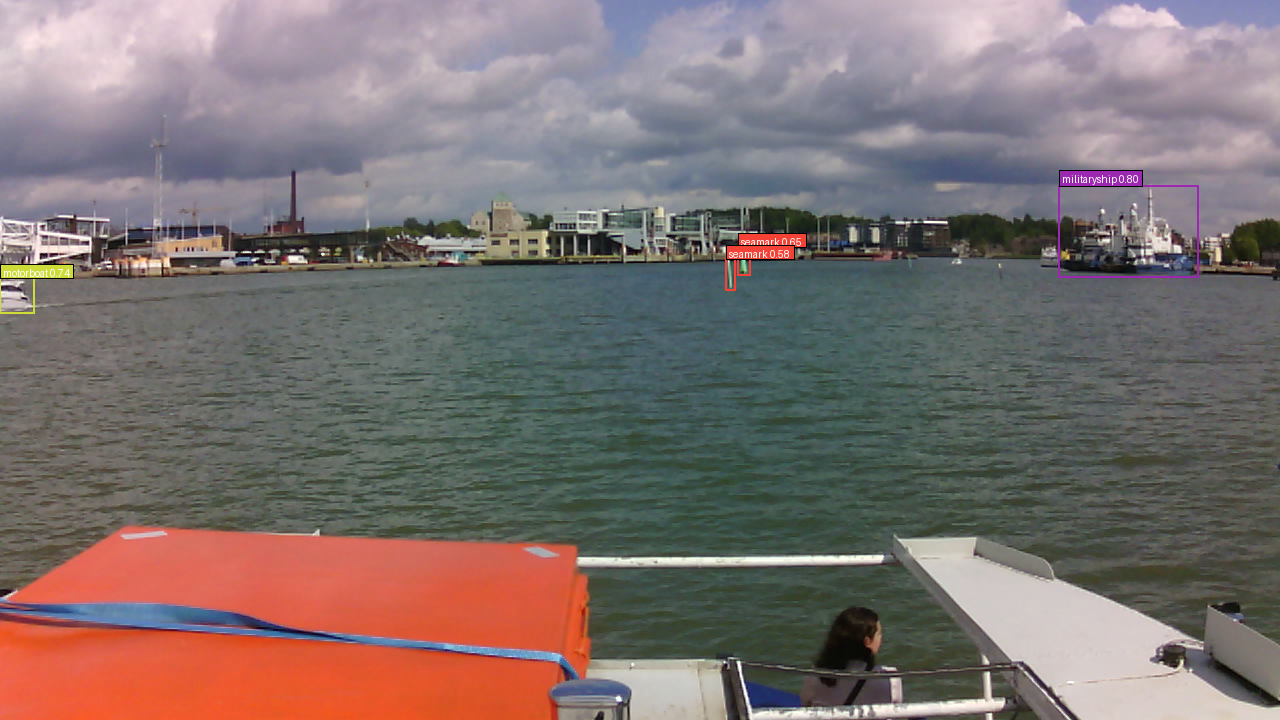

Saved: /content/pred.jpg

Class color legend:
     militaryship -> (156, 39, 176)
        motorboat -> (205, 220, 57)
          seamark -> (244, 67, 54)


In [10]:
from PIL import Image, ImageDraw, ImageFont

# ===============================
# 2) Load model
# ===============================
model = RFDETRBase(pretrain_weights=CKPT, resolution=MODEL_RESOLUTION)
model.optimize_for_inference()   # optional speed-up

# ===============================
# 3) Predict on a single image
# ===============================
dets = model.predict(IMG_PATH, threshold=SCORE_THRESHOLD)  # path / PIL / np / torch accepted

# ===============================
# 4) (Optional) Map class IDs -> names from COCO annotations
# ===============================
id2name = None
for split in ["valid", "val", "test", "train"]:
    p = os.path.join(DATASET_DIR, split, "_annotations.coco.json")
    if os.path.exists(p):
        with open(p, "r") as f:
            cats = json.load(f)["categories"]
        id2name = {c["id"]: c["name"] for c in cats}
        break

def class_label(cid: int) -> str:
    return id2name.get(cid, str(cid)) if id2name is not None else str(cid)

# ===============================
# 5) Per-class color palette (RGB tuples)
# ===============================
PALETTE = [
    (244,  67,  54),   # red
    ( 33, 150, 243),   # blue
    ( 76, 175,  80),   # green
    (255, 193,   7),   # amber
    (156,  39, 176),   # purple
    (255,  87,  34),   # deep orange
    (  0, 188, 212),   # cyan
    (205, 220,  57),   # lime
    (121,  85,  72),   # brown
    ( 63,  81, 181),   # indigo
]
def color_for_class(cid: int):
    return PALETTE[int(cid) % len(PALETTE)]

# ===============================
# 6) Draw with PIL (robust to supervision version changes)
# ===============================
image = Image.open(IMG_PATH).convert("RGB")
draw  = ImageDraw.Draw(image)

xyxy       = np.array(dets.xyxy, dtype=float)       # (N, 4)
class_ids  = np.array(dets.class_id, dtype=int)     # (N,)
conf       = np.array(dets.confidence) if getattr(dets, "confidence", None) is not None else None

# Pick a readable TrueType font if available; fallback to default
try:
    font = ImageFont.truetype("DejaVuSans.ttf", size=max(12, image.width // 80))
except Exception:
    font = ImageFont.load_default()

for i in range(len(xyxy)):
    x1, y1, x2, y2 = xyxy[i]
    cid = int(class_ids[i])
    col = color_for_class(cid)

    # Box
    # thickness ~2 for small images, thicker for large ones
    thickness = max(2, image.width // 500)
    for t in range(thickness):
        draw.rectangle([x1-t, y1-t, x2+t, y2+t], outline=col)

    # Label text
    conf_str = f" {float(conf[i]):.2f}" if conf is not None else ""
    text = f"{class_label(cid)}{conf_str}"

    # Text sizing
    # Use textbbox where available (Pillow >= 8.0) for accurate sizing
    try:
        bbox = draw.textbbox((0, 0), text, font=font)
        text_w = bbox[2] - bbox[0]
        text_h = bbox[3] - bbox[1]
    except Exception:
        text_w, text_h = draw.textsize(text, font=font)

    pad = max(2, thickness + 1)
    # Background rectangle above the box (if room), else inside top-left
    tx = int(x1)
    ty = int(y1) - text_h - 2*pad
    if ty < 0:
        ty = int(y1) + thickness  # put just inside the box

    # Draw label background (same class color), with slight dark border for legibility
    bg_rect = [tx, ty, tx + text_w + 2*pad, ty + text_h + 2*pad]
    draw.rectangle(bg_rect, fill=col)

    # Optional border around label bg for extra contrast
    border_col = (0, 0, 0)
    draw.rectangle(bg_rect, outline=border_col, width=1)

    # Put white text
    draw.text((tx + pad, ty + pad), text, fill=(255, 255, 255), font=font)

# Save + show
image.save(SAVE_PATH)
display(image)
print("Saved:", SAVE_PATH)

# ===============================
# 7) Legend (class -> color)
# ===============================
print("\nClass color legend:")
for cid in sorted(set(class_ids.tolist())):
    print(f"  {class_label(cid):>15} -> {color_for_class(cid)}")
